# 🧠 Multiple Convolutional Neural Networks (MCNN9, MCNN12, MCNN15, MCNN18)

Implements the architecture from the MDPI paper:
_'Image Classification Using Multiple Convolutional Neural Networks on the Fashion-MNIST Dataset'_ (Sensors, 2022)

We'll:
- Build 4 versions (MCNN9, MCNN12, MCNN15, MCNN18)
- Use 100% of Fashion-MNIST for training
- Train each model for 10 epochs
- Compare their accuracies.

In [ ]:
# Step 1️ — Imports
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [ ]:
# Step 2️ — Load a small subset of Fashion-MNIST (CPU friendly)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Used 100% of training data
subset_size = int(1 * len(train_data_full))
indices = np.random.choice(len(train_data_full), subset_size, replace=False)
train_data = Subset(train_data_full, indices)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

print(f"Training samples: {len(train_data)} / {len(train_data_full)}, Test samples: {len(test_data)}")

Training samples: 60000 / 60000, Test samples: 10000


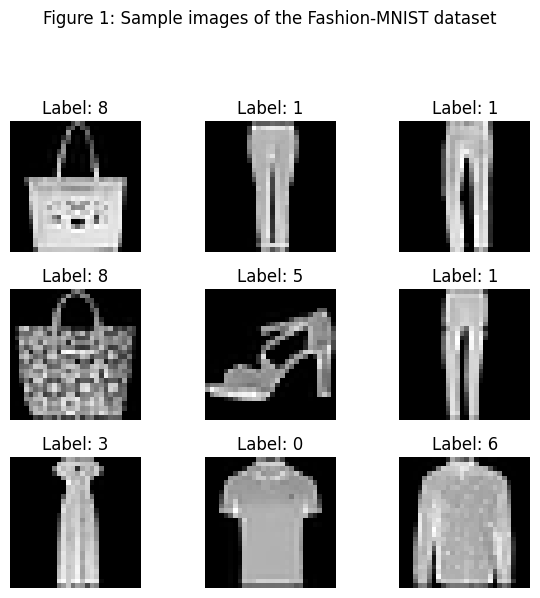

In [ ]:
# Figure 1: Sample images of the Fashion-MNIST dataset
# Assuming train_data_full is available from previous cells
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(train_data_full))
    # train_data_full returns (image_tensor, label)
    image, label = train_data_full[idx]
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.suptitle("Figure 1: Sample images of the Fashion-MNIST dataset", y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Step 3️ — Helper: convolutional block builder
def make_block(in_channels, out_channels, num_layers):
    layers = []
    for _ in range(num_layers):
        layers += [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), # Changed order: ReLU before BatchNorm
            nn.BatchNorm2d(out_channels)
        ]
        in_channels = out_channels
    layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [ ]:
# Step 4️ — MCNN model
class MCNN(nn.Module):
    def __init__(self, num_conv_per_block):
        super(MCNN, self).__init__()
        self.block1 = make_block(1, 32, num_conv_per_block)
        self.block2 = make_block(32, 64, num_conv_per_block)
        self.block3 = make_block(64, 128, num_conv_per_block)
        self.fc1 = nn.Linear(128*3*3, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(-1, 128*3*3)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# Step 5️ — Training & evaluation functions
def train_model(model, train_loader, test_loader, epochs=1):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = [] # List to store train loss per epoch
    test_losses = []  # List to store test loss per epoch

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss/len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on test set after each training epoch to get test loss
        test_acc, avg_test_loss = evaluate_model(model, test_loader, criterion) # Get test loss too
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f} - Test Acc: {test_acc:.2f}%")

    return train_losses, test_losses # Return both train and test losses

def evaluate_model(model, loader, criterion=None):
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            if criterion: # Calculate loss if criterion is provided
                loss = criterion(outputs, labels)
                total_loss += loss.item()
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(loader) if criterion else None
    return accuracy, avg_loss # Return both accuracy and avg_loss

In [ ]:
# Step 6️ — Train and evaluate all 4 MCNN models (lite mode)
configs = {'MCNN9': 3, 'MCNN12': 4, 'MCNN15': 5, 'MCNN18': 6}
results = {}
loss_histories = {'train': {}, 'test': {}} # Dictionary to store loss histories for plotting

for name, layers_per_block in configs.items():
    print(f"\n🔹 Training {name} (Conv layers per block = {layers_per_block})")
    model = MCNN(num_conv_per_block=layers_per_block)
    # Call train_model and store the returned loss history
    train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=20) # Pass test_loader
    loss_histories['train'][name] = train_losses # Store train losses
    loss_histories['test'][name] = test_losses   # Store test losses

    # Re-evaluate for final accuracy (evaluate_model now returns accuracy and loss)
    # Use a criterion for final evaluation to get proper test loss from evaluate_model
    final_acc, _ = evaluate_model(model, test_loader, nn.CrossEntropyLoss())
    results[name] = final_acc
    print(f"{name} Final Accuracy: {final_acc:.2f}%") # Changed print statement
    # Save the trained model's state dictionary
    torch.save(model.state_dict(), f"{name.lower()}_fashionmnist.pth")


🔹 Training MCNN9 (Conv layers per block = 3)
Epoch 1/20 - Train Loss: 0.3798 - Test Loss: 0.3006 - Test Acc: 88.37%
Epoch 2/20 - Train Loss: 0.2536 - Test Loss: 0.2388 - Test Acc: 91.47%
Epoch 3/20 - Train Loss: 0.2141 - Test Loss: 0.2198 - Test Acc: 92.03%
Epoch 4/20 - Train Loss: 0.1904 - Test Loss: 0.2281 - Test Acc: 92.11%
Epoch 5/20 - Train Loss: 0.1681 - Test Loss: 0.2034 - Test Acc: 92.76%
Epoch 6/20 - Train Loss: 0.1485 - Test Loss: 0.1928 - Test Acc: 93.38%
Epoch 7/20 - Train Loss: 0.1429 - Test Loss: 0.2049 - Test Acc: 92.76%
Epoch 8/20 - Train Loss: 0.1128 - Test Loss: 0.2277 - Test Acc: 92.93%
Epoch 9/20 - Train Loss: 0.0994 - Test Loss: 0.2305 - Test Acc: 92.78%
Epoch 10/20 - Train Loss: 0.0858 - Test Loss: 0.2395 - Test Acc: 92.92%
Epoch 11/20 - Train Loss: 0.0742 - Test Loss: 0.2628 - Test Acc: 93.11%
Epoch 12/20 - Train Loss: 0.0719 - Test Loss: 0.2498 - Test Acc: 93.17%
Epoch 13/20 - Train Loss: 0.0620 - Test Loss: 0.2756 - Test Acc: 92.73%
Epoch 14/20 - Train Loss: 0

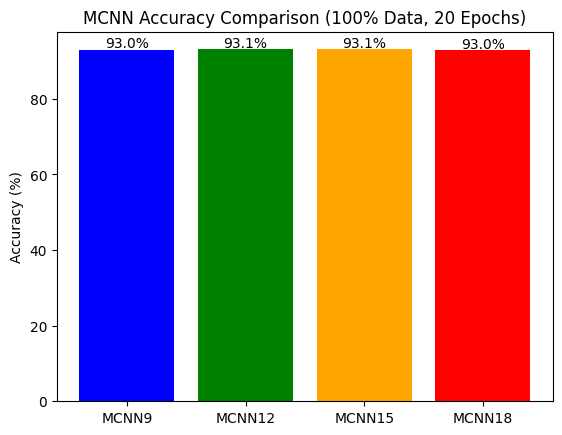


Final Results:
MCNN9: 92.99%
MCNN12: 93.08%
MCNN15: 93.11%
MCNN18: 92.97%


In [ ]:
# Step 7 — Compare results visually
plt.bar(results.keys(), results.values(), color=['blue','green','orange','red'])
plt.title('MCNN Accuracy Comparison (100% Data, 20 Epochs)')
plt.ylabel('Accuracy (%)')
for i,(k,v) in enumerate(results.items()):
    plt.text(i, v+0.5, f'{v:.1f}%', ha='center')
plt.show()

print("\nFinal Results:")
for k,v in results.items():
    print(f"{k}: {v:.2f}%")

In [ ]:
#  Evaluate MCNN15 on Kaggle Fashion-Product Dataset

!mkdir -p ~/.kaggle
from google.colab import files
files.upload()  # upload kaggle.json

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and extract dataset
!kaggle datasets download -d paramaggarwal/fashion-product-images-small -p ./data
!unzip -q ./data/fashion-product-images-small.zip -d ./data/fashion_product

# ============================================
# 🧩 Imports
# ============================================
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageOps
import pandas as pd
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Step 1: Load metadata (styles.csv)
meta_path = "./data/fashion_product/styles.csv"
df = pd.read_csv(meta_path, on_bad_lines='skip') # Changed error_bad_lines to on_bad_lines
print("Total entries in metadata:", len(df))
df = df.dropna(subset=["id", "masterCategory"])  # clean invalid rows

# Map Fashion-Product masterCategory → Fashion-MNIST-like categories
mapping = {
    "Apparel": "Topwear",
    "Accessories": "Bag",
    "Footwear": "Sandal",
    "Personal Care": "Coat",
    "Sporting Goods": "Sneaker",
    "Free Items": "Shirt",
    "Home": "Dress"
}
# Add fallback category
df["mapped_class"] = df["masterCategory"].map(mapping).fillna("Unknown")

# Assign numeric labels (only for mapped known classes)
unique_classes = sorted(df["mapped_class"].unique())
label2idx = {c: i for i, c in enumerate(unique_classes)}
df["label"] = df["mapped_class"].map(label2idx)

print("Classes mapped:", label2idx)

#  Step 2: Define preprocessing (match Fashion-MNIST)
transform_fp = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(),  # ensure 1 channel
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#  Step 3: Custom Dataset class
class FashionProductDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, limit=15000): # Increased limit to 15000
        self.df = dataframe
        self.root_dir = root_dir
        self.image_paths, self.labels = [], []
        for _, row in self.df.iterrows():
            img_path = os.path.join(root_dir, "images", f"{int(row.id)}.jpg")
            if os.path.exists(img_path):
                self.image_paths.append(img_path)
                self.labels.append(int(row.label))
            if len(self.image_paths) >= limit:
                break
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        # Convert to Fashion-MNIST-like grayscale
        img = ImageOps.fit(img, (28,28), method=Image.BILINEAR, centering=(0.5,0.5))
        img = ImageOps.grayscale(img)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

#  Step 4: Load dataset
fp_dataset = FashionProductDataset(df, "./data/fashion_product", transform=transform_fp, limit=15000)
fp_loader = DataLoader(fp_dataset, batch_size=64, shuffle=False)
print(f"Loaded {len(fp_dataset)} Fashion-Product samples.")

#  Step 5: Load MCNN15 model

# Load trained model
model = MCNN(num_conv_per_block=5).to(device) # Instantiate MCNN from earlier cell
model.load_state_dict(torch.load("mcnn15_fashionmnist.pth", map_location=device))
model.eval()

#  Step 6: Evaluate on Fashion-Product dataset
from sklearn.metrics import accuracy_score, classification_report

softmax = torch.nn.Softmax(dim=1)
all_preds, all_targets, all_conf = [], [], []

with torch.no_grad():
    for imgs, labels in tqdm(fp_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        probs = softmax(model(imgs))
        conf, preds = probs.max(dim=1)
        all_conf.extend(conf.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

avg_conf = np.mean(all_conf)
acc = accuracy_score(all_targets, all_preds)

print(f"\n Evaluation Results on Fashion-Product Dataset:")
print(f"Average Top-1 Confidence: {avg_conf:.3f}")
print(f"Classification Accuracy: {acc*100:.2f}%")
print("\nPer-class report:")
print(classification_report(all_targets, all_preds, digits=4))

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
fashion-product-images-small.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./data/fashion_product/images/10000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Using device: cuda
Total entries in metadata: 44424
Classes mapped: {'Bag': 0, 'Coat': 1, 'Dress': 2, 'Sandal': 3, 'Shirt': 4, 'Sneaker': 5, 'Topwear': 6}
Loaded 15000 Fashion-Product samples.


100%|██████████| 235/235 [00:10<00:00, 22.11it/s]


✅ Evaluation Results on Fashion-Product Dataset:
Average Top-1 Confidence: 0.815
Classification Accuracy: 5.31%

Per-class report:
              precision    recall  f1-score   support

           0     0.3210    0.1722    0.2241      3793
           1     0.1720    0.0330    0.0554       818
           2     0.0000    0.0000    0.0000         1
           3     0.0000    0.0000    0.0000      3022
           4     0.0000    0.0000    0.0000        30
           5     0.0000    0.0000    0.0000         7
           6     0.9431    0.0158    0.0311      7329
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0
           9     0.0000    0.0000    0.0000         0

    accuracy                         0.0531     15000
   macro avg     0.1436    0.0221    0.0311     15000
weighted avg     0.5514    0.0531    0.0749     15000




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


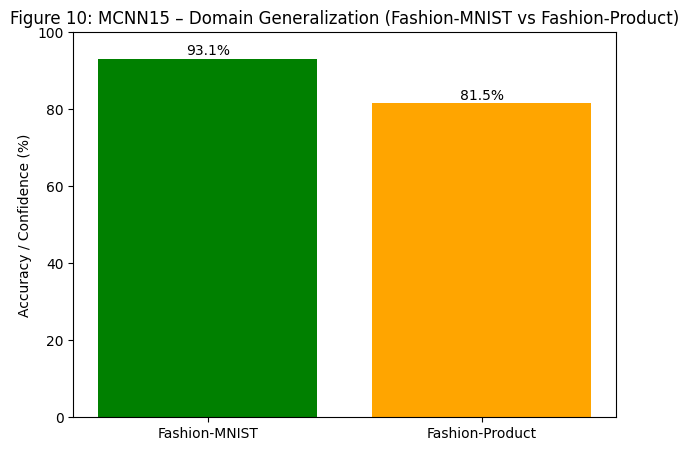

In [ ]:

results = {}
for name, layers_per_block in configs.items():
    # Assuming final accuracy was the last test accuracy recorded for the first epoch
    if name in loss_histories['test'] and loss_histories['test'][name]:
        model_reloaded = MCNN(num_conv_per_block=layers_per_block).to(device)
        model_reloaded.load_state_dict(torch.load(f"{name.lower()}_fashionmnist.pth", map_location=device))
        model_reloaded.eval()
        re_evaluated_acc, _ = evaluate_model(model_reloaded, test_loader, nn.CrossEntropyLoss())
        results[name] = re_evaluated_acc
    else:
        print(f"Warning: Could not restore accuracy for {name}")

updated_comparison_results = {
    "Fashion-MNIST": results['MCNN15'],
    "Fashion-Product": avg_conf * 100  # Convert confidence to percentage
}

plt.figure(figsize=(7, 5))
plt.bar(updated_comparison_results.keys(), updated_comparison_results.values(), color=["green","orange"])
plt.title("Figure 10: MCNN15 – Domain Generalization (Fashion-MNIST vs Fashion-Product)")
plt.ylabel("Accuracy / Confidence (%)")
for k,v in updated_comparison_results.items():
    plt.text(k, v + 1, f"{v:.1f}%", ha="center")
plt.ylim(0, 100) # Ensure y-axis covers the full range for percentages
plt.show()

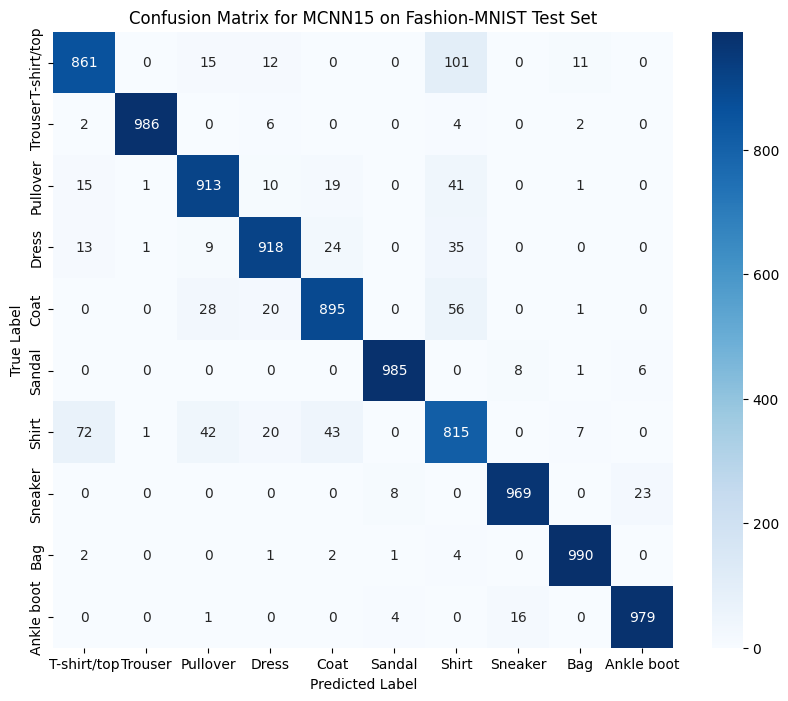

In [ ]:
# Ensure device is defined (it should be from previous cells)
if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Load the MCNN15 model
mcnn15_model = MCNN(num_conv_per_block=5).to(device)
# Load the state dictionary from the saved file
mcnn15_model.load_state_dict(torch.load("mcnn15_fashionmnist.pth", map_location=device))
mcnn15_model.eval() # Set model to evaluation mode

# Get predictions on the Fashion-MNIST test set
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mcnn15_model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Define class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MCNN15 on Fashion-MNIST Test Set')
plt.show()

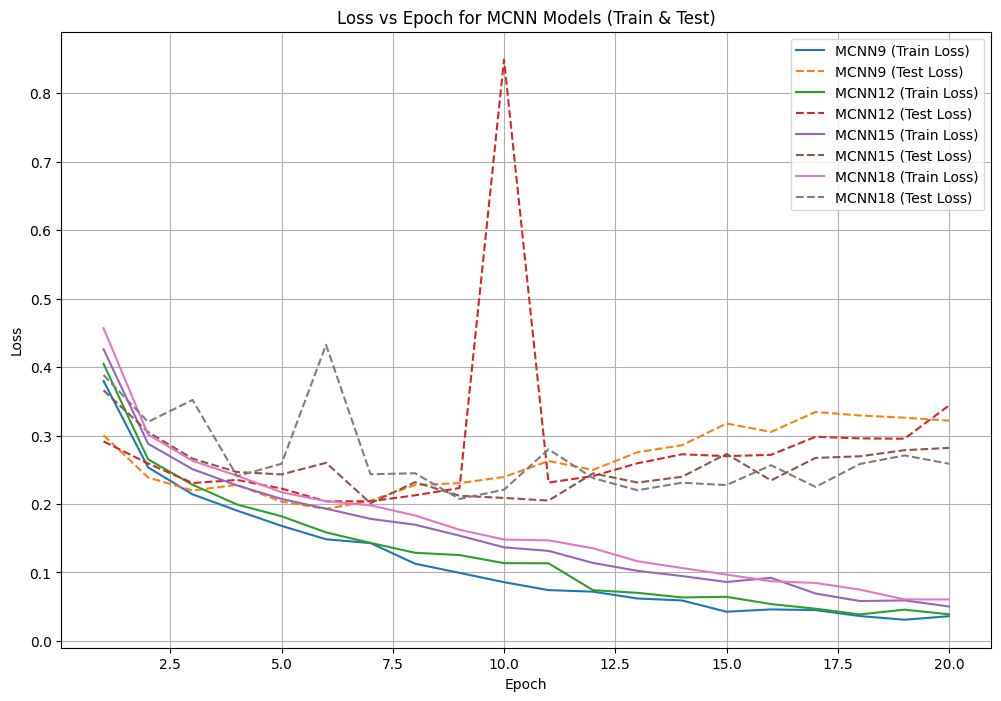

In [ ]:
# Figure: Loss vs Epoch Graph for all MCNN models (Train & Test)
plt.figure(figsize=(12, 8)) # Increased figure size for better readability

# Check if loss_histories is populated before plotting
if 'loss_histories' in locals() and loss_histories:
    for name in configs.keys(): # Iterate through model names
        if name in loss_histories['train'] and name in loss_histories['test']:
            # Plot training loss
            plt.plot(range(1, len(loss_histories['train'][name]) + 1), loss_histories['train'][name],
                     label=f'{name} (Train Loss)', linestyle='-')
            # Plot test loss
            plt.plot(range(1, len(loss_histories['test'][name]) + 1), loss_histories['test'][name],
                     label=f'{name} (Test Loss)', linestyle='--')
        else:
            print(f"Loss histories for {name} not found. Please ensure training cell was executed.")
else:
    print("loss_histories variable is not populated. Please ensure the training cell (Step 6) was executed.")

plt.title('Loss vs Epoch for MCNN Models (Train & Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()